# Libraries
---

In [1]:
# System Libraires
import os
import pickle
import json
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
from scipy.interpolate import interp1d
import mne  # For multitaper PSD
from mne.time_frequency import psd_array_multitaper
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

import warnings

DATAFILES_DIR = '../Datafiles'
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'
COLLECTIONFILES_DIR = '../data-collections'

# Continuous Wavelet Transformation/Power Spectral Density

We will import the files into a DataFrame and then use them to process continuous wavelet sonographs and Power Spectral Density to capture better tremor and tonic movements, which represent each feature as a channel, allowing us to use Convolutional Neural Networks (CNN) with pure image feature extraction algorithms. This way, we can get a better level of efficiency, but we need to compare this against data outside of our dataset, which lacks the additional two channels that we are getting from the ultrasonics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import signal

class RawCNNTCNPSDModel(nn.Module):
    """Condensed IMU-only model with essential components"""
    def __init__(self, input_channels=6, num_classes=4, seq_len=600, fs=50.0):
        super().__init__()
        self.seq_len = seq_len
        self.fs = fs
        
        # Multi-scale feature extractor (combined into single module)
        self.feature_extractor = nn.ModuleDict({
            'large': nn.Sequential(
                nn.Conv1d(input_channels, 32, 15, padding=7, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 15, padding=7),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(150)
            ),
            'medium': nn.Sequential(
                nn.Conv1d(input_channels, 32, 11, padding=5, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 11, padding=5),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(150)
            ),
            'small': nn.Sequential(
                nn.Conv1d(input_channels, 32, 7, padding=3, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 7, padding=3),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(150)
            )
        })
        
        # Temporal processing
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(96, 64, 3, padding=1),  # 96 from 3x32 multi-scale
            nn.BatchNorm1d(64),
            nn.GELU(),
            *[nn.Sequential(  # Simplified TCN blocks
                nn.Conv1d(64, 64, 3, padding=2**i, dilation=2**i),
                nn.BatchNorm1d(64),
                nn.GELU(),
                nn.Dropout(0.2)
            ) for i in range(5)]
        )
        
        # Frequency domain processing
        self.psd_processor = nn.Sequential(
            nn.Conv1d(5, 16, 3, padding=1),  # 5 PSD features per channel
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.AdaptiveAvgPool1d(32)
        )
        
        # Temporal attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(64+32, 64),  # Combined time + freq features
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def compute_psd(self, x):
        """Inlined PSD computation"""
        batch_size, channels, seq_len = x.shape
        x_np = x.detach().cpu().numpy()
        psd_features = []
        
        for b in range(batch_size):
            for c in range(channels):
                freqs, psd = signal.welch(x_np[b, c], fs=self.fs, nperseg=min(256, seq_len//4))
                tremor_mask = (freqs >= 4) & (freqs <= 12)
                movement_mask = (freqs >= 0.5) & (freqs <= 4)
                
                features = np.array([
                    np.sum(psd[tremor_mask]) / (np.sum(psd) + 1e-8),
                    np.sum(psd[movement_mask]) / (np.sum(psd) + 1e-8),
                    np.log(np.sum(psd) + 1e-8),
                    np.mean(psd),
                    np.std(psd)
                ])
                psd_features.append(features)
        
        return torch.tensor(np.array(psd_features).reshape(batch_size, channels, 5), 
                          dtype=x.dtype, device=x.device)

    def forward(self, x):
        # x shape: [batch, time_steps, channels, seq_len]
        batch_size = x.shape[0]
        
        # Process last time step only (can modify to process all if needed)
        imu_data = x[:, -1, :, :]  # [batch, channels, seq_len]
        
        # Multi-scale feature extraction
        features = [ext(imu_data) for ext in self.feature_extractor.values()]
        combined_features = torch.cat(features, dim=1)  # [batch, 96, 150]
        
        # Temporal processing
        temporal_features = self.temporal_conv(combined_features)  # [batch, 64, 150]
        temporal_features = temporal_features.mean(dim=-1)  # [batch, 64]
        
        # Frequency domain processing
        psd_feats = self.compute_psd(imu_data)  # [batch, channels, 5]
        psd_feats = psd_feats.mean(dim=1)  # Average across channels [batch, 5]
        psd_feats = self.psd_processor(psd_feats.unsqueeze(-1)).squeeze(-1)  # [batch, 32]
        
        # Feature fusion with attention
        combined = torch.cat([temporal_features, psd_feats], dim=1)  # [batch, 96]
        attn_weights = self.temporal_attention(combined)  # [batch, 1]
        weighted_features = attn_weights * temporal_features  # [batch, 64]
        
        # Classification
        return self.classifier(weighted_features)

class FocalLoss(nn.Module):
    """Condensed Focal Loss"""
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1-pt)**self.gamma * ce_loss).mean()

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np
from glob import glob

class IMUSonarHierarchicalDataset(Dataset):
    def __init__(self, root_dir, label_map=None, transform=None):
        self.samples = []
        self.transform = transform
        self.label_map = label_map or {}

        for csv_path in glob(os.path.join(root_dir, '**', '*.csv'), recursive=True) + \
                        glob(os.path.join(root_dir, '**', '*.CSV'), recursive=True):
            parts = os.path.normpath(csv_path).split(os.sep)

            # Skip invalid cases
            if len(parts) < 5:
                continue

            # Traverse upward, skipping 'variant' directories
            labels = []
            count = 0
            i = len(parts) - 2  # start from the directory containing the file
            while i >= 0 and count < 2:
                if parts[i].lower() != 'variants':
                    labels.insert(0, parts[i])
                    count += 1
                i -= 1

            if len(labels) != 2:
                continue  # skip if we couldn’t find 2 valid label levels

            label_key = '_'.join(labels)
            if label_key not in self.label_map:
                self.label_map[label_key] = len(self.label_map)

            self.samples.append((csv_path, self.label_map[label_key]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        csv_path, label = self.samples[idx]
        df = pd.read_csv(csv_path)

        # Drop timestamp (assuming it's column 0), keep 8 sensor channels
        sensor_data = df.iloc[:, 1:].values.astype(np.float32)
        if sensor_data.shape != (600, 8):
            raise ValueError(f"Invalid shape {sensor_data.shape} in {csv_path}")

        # Per-sample channel-wise normalization
        sensor_data = (sensor_data - sensor_data.mean(axis=0)) / (sensor_data.std(axis=0) + 1e-6)
        sensor_data = sensor_data.T  # shape: (8, 600)

        if self.transform:
            sensor_data = self.transform(sensor_data)

        return torch.tensor(sensor_data), torch.tensor(label)


In [3]:
import os
import json
import random

def generate_json_splits(root_dir, output_dir, train_ratio=0.8, seed=42):
    # Use your existing dataset class to parse files and labels
    dataset = IMUSonarHierarchicalDataset(root_dir)
    samples = dataset.samples  # list of (csv_path, label)
    label_map = dataset.label_map

    # Convert to JSON-compatible format
    json_samples = [{'path': path, 'label': label} for path, label in samples]

    # Shuffle and split
    random.seed(seed)
    random.shuffle(json_samples)
    split_idx = int(len(json_samples) * train_ratio)
    train_samples = json_samples[:split_idx]
    test_samples = json_samples[split_idx:]

    # Save to JSON
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, 'train.json'), 'w') as f:
        json.dump(train_samples, f, indent=2)
    with open(os.path.join(output_dir, 'test.json'), 'w') as f:
        json.dump(test_samples, f, indent=2)
    with open(os.path.join(output_dir, 'label_map.json'), 'w') as f:
        json.dump(label_map, f, indent=2)

    print(f"Saved {len(train_samples)} training samples and {len(test_samples)} test samples.")
    print(f"Labels: {len(label_map)} classes written to label_map.json.")

# Generate the files
generate_json_splits(
    root_dir=COLLECTIONFILES_DIR,
    output_dir=DATAFILES_DIR,
    train_ratio=0.8,
    seed=42
)

Saved 21583 training samples and 5396 test samples.
Labels: 28 classes written to label_map.json.


In [126]:
class IMUSonarFromJSON(Dataset):
    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} or {}
        self.target_length = target_length
        self.debug = debug
        self.cols = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

    def __len__(self):
        return len(self.samples)

    def _resample_to_uniform(self, df):
        # 1. Ensure required columns
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
        signals = df[self.cols].values.astype(np.float32)
    
        # 2. Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        # 3. Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)))
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
    
        # 4. Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.debug: print(f"Post-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
    
        # 5. Return shape (C, T)
        return resampled.T  # (channels, time)

    def __getitem__(self, idx):
        item = self.samples[idx]
        path = item['path']
        label_str = item['label']
        
        df = pd.read_csv(path)
        # print(df)
        # data = df.values.astype(np.float32)
        # print(data)
        # df_f32 = df.values.astype(np.float32)  # drop timestamp, keep 8 sensors
        # print(df_f32)

        # # Handle variable-length sequences
        # if len(data) > self.target_length:
        #     # If too long, take the first target_length samples
        #     data = data[:self.target_length]
        # elif len(data) < self.target_length:
        #     # If too short, pad with zeros
        #     pad_length = self.target_length - len(data)
        #     data = np.pad(data, ((0, pad_length), (0, 0)), mode='constant')

        # # Normalize per-sample
        # data = (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-6)
        # data = data.T  # (8, target_length)

        data = self._resample_to_uniform(df)
        # print(data)

        if self.transform:
            data = self.transform(data)

        self.label = self.label_map[label_str] if self.label_map else label_str
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label_str, dtype=torch.long)

In [5]:
class RawCNNTCNPSDModel(nn.Module):
    """Condensed IMU-only model with MaxPool instead of AdaptiveAvgPool"""
    def __init__(self, input_channels=6, num_classes=4, seq_len=600, fs=50.0):
        super().__init__()
        self.seq_len = seq_len
        self.fs = fs
        
        # Multi-scale feature extractor with MaxPool
        self.feature_extractor = nn.ModuleDict({
            'large': nn.Sequential(
                nn.Conv1d(input_channels, 32, 15, padding=7, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 15, padding=7),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.MaxPool1d(4)  # Changed to MaxPool with fixed size
            ),
            'medium': nn.Sequential(
                nn.Conv1d(input_channels, 32, 11, padding=5, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 11, padding=5),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.MaxPool1d(4)  # Changed to MaxPool
            ),
            'small': nn.Sequential(
                nn.Conv1d(input_channels, 32, 7, padding=3, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 7, padding=3),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.MaxPool1d(4)  # Changed to MaxPool
            )
        })
        
        # Temporal processing
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(96, 64, 3, padding=1),  # 96 from 3x32 multi-scale
            nn.BatchNorm1d(64),
            nn.GELU(),
            *[nn.Sequential(  # Simplified TCN blocks
                nn.Conv1d(64, 64, 3, padding=2**i, dilation=2**i),
                nn.BatchNorm1d(64),
                nn.GELU(),
                nn.Dropout(0.2)
            ) for i in range(5)]
        )
        
        # Frequency domain processing with MaxPool
        # self.psd_processor = nn.Sequential(
        #     nn.Conv1d(5, 16, 3, padding=1),
        #     nn.BatchNorm1d(16),
        #     nn.GELU(),
        #     nn.MaxPool1d(2)  # Changed to MaxPool
        # )
        self.psd_processor = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Temporal attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(64+16, 64),  # Combined time + freq features
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def compute_psd(self, x):
        """Inlined PSD computation"""
        batch_size, channels, seq_len = x.shape
        x_np = x.detach().cpu().numpy()
        psd_features = []
        
        for b in range(batch_size):
            for c in range(channels):
                freqs, psd = welch(x_np[b, c], fs=self.fs, nperseg=min(256, seq_len//4))
                tremor_mask = (freqs >= 4) & (freqs <= 12)
                movement_mask = (freqs >= 0.5) & (freqs <= 4)
                
                features = np.array([
                    np.sum(psd[tremor_mask]) / (np.sum(psd) + 1e-8),
                    np.sum(psd[movement_mask]) / (np.sum(psd) + 1e-8),
                    np.log(np.sum(psd) + 1e-8),
                    np.mean(psd),
                    np.std(psd)
                ])
                psd_features.append(features)
        
        return torch.tensor(np.array(psd_features).reshape(batch_size, channels, 5), 
                          dtype=x.dtype, device=x.device)

    def forward(self, x):
        # x shape: [batch, time_steps, channels, seq_len]
        batch_size = x.shape[0]
        
        # Process last time step only (can modify to process all if needed)
        imu_data = x[:, -1, :, :]  # [batch, channels, seq_len]
        
        # Multi-scale feature extraction
        features = [ext(imu_data) for ext in self.feature_extractor.values()]
        combined_features = torch.cat(features, dim=1)  # [batch, 96, seq_len']
        
        # Temporal processing
        temporal_features = self.temporal_conv(combined_features)  # [batch, 64, seq_len']
        temporal_features = temporal_features.mean(dim=-1)  # [batch, 64]
        
        # Frequency domain processing
        psd_feats = self.compute_psd(imu_data)  # [batch, channels, 5]
        psd_feats = psd_feats.mean(dim=1)  # Average across channels [batch, 5]
        # print(psd_feats.shape)
        # psd_feats = self.psd_processor(psd_feats.unsqueeze(-1)).squeeze(-1)  # [batch, 16]
        psd_feats = self.psd_processor(psd_feats)  # Output: [batch, 16]
        
        # Feature fusion with attention
        combined = torch.cat([temporal_features, psd_feats], dim=1)  # [batch, 80]
        attn_weights = self.temporal_attention(combined)  # [batch, 1]
        weighted_features = attn_weights * temporal_features  # [batch, 64]
        
        # Classification
        return self.classifier(weighted_features)

In [6]:
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

print(label_map)
train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=train_dataset.label_map)
print("Label mapping:", train_dataset.label_map)
print("Test Label mapping:", test_dataset.label_map)

print(f'This is the Size of train set: {len(train_dataset)}')

{'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}
Label mapping: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 16: 'normal_stairs', 17

In [7]:
# import os
# import gc
# import json
# import torch
# import random
# import numpy as np
# import pandas as pd
# from time import time
# from torch import nn
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from torch.optim import Adam
# from collections import defaultdict

# ---------------- Memory & Device Config ----------------
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Utilities ----------------
def pad_to_multiple(tensor, multiple, pad_value=0, dim=0):
    size = tensor.size(dim)
    if size % multiple == 0:
        return tensor
    pad_size = multiple - (size % multiple)
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)
print("Label mapping:", train_dataset.label_map)

label_dict = train_dataset.label_map
num_classes = len(label_dict)
input_shape = (8, 600)
time_steps = 8
batch_size = 16
epochs = 25
accumulation_steps = 2

x_train = torch.stack([x for x, _ in train_dataset])
y_train = torch.tensor([y for _, y in train_dataset])
x_test = torch.stack([x for x, _ in test_dataset])
y_test = torch.tensor([y for _, y in test_dataset])

x_train = pad_to_multiple(x_train, time_steps)
y_train = pad_to_multiple(y_train, time_steps, pad_value=-100)
x_test = pad_to_multiple(x_test, time_steps)
y_test = pad_to_multiple(y_test, time_steps, pad_value=-100)

n_train_batches = x_train.size(0) // time_steps
n_test_batches = x_test.size(0) // time_steps

x_train_seq = x_train.view(n_train_batches, time_steps, *input_shape)
y_train_seq = y_train.view(n_train_batches, time_steps)
x_test_seq = x_test.view(n_test_batches, time_steps, *input_shape)
y_test_seq = y_test.view(n_test_batches, time_steps)

y_train_last = y_train_seq[:, -1]
y_test_last = y_test_seq[:, -1]

print(f"Training data shape: {x_train_seq.shape}")
print(f"Training labels shape: {y_train_last.shape}")
print(f"Test data shape: {x_test_seq.shape}")
print(f"Test labels shape: {y_test_last.shape}")

# ---------------- Model ----------------
model = RawCNNTCNPSDModel(input_channels=8, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # print("Input shape to model:", inputs.shape)  # Should be (1, 8, 8, 600)
        # print("Min/max/mean/std of input:", inputs.min(), inputs.max(), inputs.mean(), inputs.std())


        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            x_chunk = inputs[i:i + chunk_size].to(device)
            y_chunk = labels[i:i + chunk_size].to(device)
            outputs = model(x_chunk)
            total_loss += criterion(outputs, y_chunk).item() * x_chunk.size(0)
            _, predicted = torch.max(outputs, 1)
            mask = y_chunk != -100
            correct += (predicted[mask] == y_chunk[mask]).sum().item()
            del x_chunk, y_chunk, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()
    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Label mapping: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 16: 'normal_stairs', 17: 'tonic_running', 18: 'tonic_walking', 19: 'tonic_standing', 20: 'tonic_sitting', 21: 'tonic_laying', 22: 'tonic_stairs', 23: 'tremor_falling', 24: 'postural_running', 25: 'postural_stairs', 26: 'normal_falling', 27: 'tonic_falling'}
Training data shape: torch.Size([2698, 8, 8, 600])
Training labels shape: torch.Size([2698])
Test data shape: torch.Size([675, 8, 8, 600])
Test labels shape: torch.Size([675])
Epoch 1/25 - 8.7s
Train Loss: 2.7770 Acc: 0.2121
Val Loss: 2.0563 Acc: 0.3709
Epoch End Memory: Alloc=0.03GB, Reserved=0.09GB

Epoch 2/

## Save Model

Save the trained model for later use

In [8]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCM-PSD-LSTM_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCM-PSD-LSTM_training_history_99percent.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [9]:
# print("x_train shape:", x_train.shape)
x_train_tensor = x_train
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train_tensor shape: torch.Size([21584, 8, 600])
x_train_tensor stats: mean = 7.069490826072666e-12 std = 0.9999220371246338
Sample input min/max: -6.231083869934082 5.382981777191162


# Validations
---

This will validate that the trained data can properly validate the test data set after training

In [10]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)
model = RawCNNTCNPSDModel(input_channels=8, num_classes=len(label_dict)).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCM-PSD-LSTM_model_weights_99percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

<All keys matched successfully>

## Random Prediction

Pick a random sample from the HandGestures wavelets and do a prediction

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.signal import welch
from pathlib import Path
from scipy.interpolate import interp1d

class ProcessRawPSDSingle:
    def __init__(self, device=None, base_freq=50, target_len=600, psd_bands=5):
        self.base_freq = base_freq
        self.target_len = target_len
        self.psd_bands = psd_bands

        if device is not None:
            self.device = device
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    def _normalize_signal(self, data):
        return (data - np.median(data, axis=0)) / (np.std(data, axis=0) + 1e-6)

    def _resample_to_uniform(self, df):
        timestamps = df['Timestamp(ms)'].values.astype(np.float64)
        cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
                'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
        signals = df[cols].values

        # Remove duplicate timestamps
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        duration_s = (timestamps[-1] - timestamps[0]) / 1000.0
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_len)

        resampled = np.zeros((self.target_len, len(cols)))
        for i in range(len(cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return self._normalize_signal(resampled), cols

    def _compute_psd(self, signal, fs=50):
        _, psd = welch(signal, fs=fs, nperseg=min(128, len(signal)))
        psd_binned = np.array_split(psd, self.psd_bands)
        return np.array([np.mean(b) for b in psd_binned])

    def process_single_csv(self, csv_path):
        df = pd.read_csv(csv_path)
        resampled, cols = self._resample_to_uniform(df)  # shape: (T, 6)

        # Prepare raw IMU tensor
        raw_tensor = torch.tensor(resampled.T.reshape(1, 6, 1, self.target_len), dtype=torch.float32)

        # Compute PSD from selected IMU channels (e.g., first 3: accel)
        psd_feats = np.stack([self._compute_psd(resampled[:, i], fs=self.base_freq) for i in range(3)])
        psd_vector = psd_feats.mean(axis=0)  # average across 3 channels
        psd_tensor = torch.tensor(psd_vector, dtype=torch.float32).unsqueeze(0)  # shape: [1, psd_bands]

        return raw_tensor.to(self.device), psd_tensor.to(self.device)

    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        raw_tensor, psd_tensor = self.process_single_csv(csv_path)

        # Infer label from path
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        if len(label_parts) < 2:
            label_name = "unknown"
        else:
            label_name = label_parts[1]

        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"

        # Run inference
        model.to(self.device)
        model.eval()
        with torch.no_grad():
            outputs = model(raw_tensor, psd_tensor)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

        prob_dict = {
            id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
            for i, p in enumerate(probs)
        }

        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": prob_dict
        }


In [64]:
class ProcessRawPSDSingle:
    def __init__(self, device=None, base_freq=50, target_len=600):
        self.base_freq = base_freq
        self.target_len = target_len
        self.device = device or self._get_device()
        
        # Training's exact channel configuration
        self.channel_order = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

    def _get_device(self):
        """Exactly matches training device setup"""
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            torch.mps.manual_seed(42)
        elif torch.cuda.is_available():
            device = torch.device("cuda")
            torch.cuda.manual_seed(42)
        else:
            device = torch.device("cpu")
        return device

    def _normalize_signal(self, data):
        """EXACT training normalization (mean/std with 1e-8 epsilon)"""
        return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-8)

    def _resample_to_uniform(self, df):
        """Identical to training's preprocessing pipeline"""
        # Your existing implementation matching training exactly
        ...

    def process_single_csv(self, csv_path):
        """Produces IDENTICAL format to training batches"""
        df = pd.read_csv(csv_path)
        resampled = self._resample_to_uniform(df)  # [600, 8]
        
        # Convert to tensor matching training EXACTLY
        tensor = torch.tensor(resampled.T, dtype=torch.float32)  # [8, 600]
        
        # Add timestep dimension to match training's [8, 8, 600] structure
        # For inference we'll use just one timestep: [8, 1, 600]
        return tensor.unsqueeze(1).to(self.device)  # [8, 1, 600]

    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        """Handles the dimension mismatch between training and inference"""
        # Process to [8, 1, 600] (one timestep)
        processed_data = self.process_single_csv(csv_path)
        
        # Model expects [batch, channels, timesteps, seq_len]
        model_input = processed_data.permute(1, 0, 2).unsqueeze(0)  # [1, 8, 1, 600]
        
        # Compare with actual training sample
        train_sample = next(iter(train_loader))[0][0]  # First training sample [8, 8, 600]
        diff = (processed_data[:, 0] - train_sample[:, 0]).abs().mean()
        
        print(f"Train sample shape: {train_sample.shape}")
        print(f"Model input shape: {model_input.shape}")
        print(f"Difference (first timestep): {diff.item()}")

        # Run inference
        model.eval()
        with torch.no_grad():
            outputs = model(model_input)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        
        # Get true label info
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        label_name = f'{label_parts[1]}_{label_parts[0]}' if len(label_parts) >= 2 else "unknown"

        print(f'This is the label name: {label_name}')
        print(f'This is the label list: {label_parts}')
        
        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"
    
        # Get prediction
        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
    
        # # Verification metrics (removed train comparison to avoid device conflict)
        # verification = {
        #     "input_shape": list(input_tensor.shape),
        #     "input_mean": float(input_tensor.mean().item()),
        #     "input_std": float(input_tensor.std().item()),
        #     "top_3_predictions": [
        #         (id_to_label_name.get(index_to_label_id[i], f"ID_{i}"), float(p)) 
        #         for i, p in sorted(enumerate(probs), key=lambda x: -x[1])[:3]
        #     ]
        # }
    
        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": {
                id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
                for i, p in enumerate(probs)
            }
        }

In [39]:
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

inference = ProcessRawPSDSingle()
result = inference.predict_from_csv(
    csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
)


In [143]:
class ProcessSingleRawOnly(IMUSonarFromJSON):
    def __init__(self, sample_data, label_map=None, transform=None, device=None, target_len=600):
        print(f'File: {sample_data}')
        self.sample = sample_data
        
        self.transform = transform
        if label_map is not None: self.label_map = {v: k for k, v in label_map.items()}
        else: self.label_map = {}
        
        self.target_length = target_len
        self.cols = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

        # Class-specific initializers
        self.device = device or self._get_device()
        self.time_steps = 8  # Must match training
        self.debug = True

    def _get_device(self):
        """Matches training device setup exactly"""
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            torch.mps.manual_seed(42)
        elif torch.cuda.is_available():
            device = torch.device("cuda")
            torch.cuda.manual_seed(42)
        else:
            device = torch.device("cpu")
        return device

    def _pad_single_sample(tensor, multiple, pad_value=0, dim=0):
        """Pad a single tensor to match training padding behavior"""
        size = tensor.size(dim)
        if size % multiple == 0:
            return tensor
        pad_size = multiple - (size % multiple)
        pad_shape = list(tensor.shape)
        pad_shape[dim] = pad_size
        pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
        return torch.cat([tensor, pad_tensor], dim=dim)

    def process_single_csv(self):
        """Produces EXACTLY [8,600] like training samples"""
        item = self.sample
        path = item['path']
        label_str = item['label']
        
        df = pd.read_csv(path)

        data = self._resample_to_uniform(df)

        if self.transform:
            data = self.transform(data)

        self.label = self.label_map[label_str] if self.label_map else label_str
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label_str, dtype=torch.long)

    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        """Matches training batch structure exactly"""

        # === DEBUG: Verify parameters match ===
        print("\n=== PARAMETER VERIFICATION ===")
        
        # Get training params from dataset (assuming train_dataset is available)
        if 'train_dataset' in globals():
            print("TRAINING PARAMS:")
            print(f"Target length: {train_dataset.target_length}")
            print(f"Columns: {train_dataset.cols}")
            
        # Print inference params from current instance
        print("\nINFERENCE PARAMS:")
        print(f"Target length: {self.target_length}")
        print(f"Columns: {self.cols}")
        print(f"Device: {self.device}")
        
        # Get raw [8,600] sample
        raw_data, true_label = self.process_single_csv()
        
        # Additional debug - verify sample stats
        print("\nSAMPLE STATS:")
        print(f"Raw data shape: {raw_data.shape}")
        print(f"Mean: {raw_data.mean().item():.4f}, Std: {raw_data.std().item():.4f}")
        print(f"Min: {raw_data.min().item():.4f}, Max: {raw_data.max().item():.4f}")
        
        # Create fake "batch" of 8 identical samples to match training's [batch,8,8,600]
        # This simulates how training pads multiple samples together
        # model_input = raw_data.unsqueeze(0).repeat(1, 8, 1, 1).unsqueeze(0)  # [1,8,8,600]
        # model_input = model_input.to(device)
        # Reshape to what Conv1d expects: [batch_size, channels, sequence_length]
        model_input = raw_data.unsqueeze(0).unsqueeze(0)  # [1, 1, 8, 600]
        model_input = model_input.repeat(1, 8, 1, 1)      # [1, 8, 8, 600]
        model_input = model_input.to(device)

        # Create matching label tensor [batch=1]
        labels = torch.tensor([true_label], dtype=torch.long).to(device)

        # Verification - compare first channel with training
        print(f"Model input shape: {model_input.shape}")  # Should be [1, 8, 8, 600]
        print(f"Labels shape: {labels.shape}")           # Should be [1]
        train_sample = next(iter(train_loader))[0][0,0]  # First sample, first timestep [8,600]
        raw_data = raw_data.to(device)
        train_sample = train_sample.to(device)
        diff = (raw_data - train_sample).abs().mean()
        
        print(f"Train sample shape: {train_sample.shape}")
        print(f"Model input shape: {model_input.shape}")
        print(f"Difference (first channel): {diff.item()}")
        
        # Label handling (unchanged from your original)
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        label_name = f"{label_parts[1]}_{label_parts[0]}" if len(label_parts) >= 2 else "unknown"
        
        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"

        # Inference
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(model_input)
            # Run through model EXACTLY like validation
        model.eval()
        with torch.no_grad():
            outputs = model(model_input)
            val_loss = criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            
            # Apply training's mask logic
            mask = labels != -100
            is_correct = (predicted[mask] == labels[mask]).sum().item()
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": {
                id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
                for i, p in enumerate(probs)
            }
        }

In [144]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Load label mappings
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Move model to device
model = model.to(device)

# Verification 1: Check model weights
print("\n=== Model Verification ===")
print("Model first conv weight mean:", model.feature_extractor['large'][0].weight.mean().item())
print(f"Model device: {next(model.parameters()).device}")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
train_sample, train_label = next(iter(train_loader))
train_sample = train_sample.to(device)  # Move to same device as model
train_label = train_label.to(device)

with torch.no_grad():
    model.eval()
    output = model(train_sample[:1])  # Test on first training sample
    predicted_label = torch.argmax(output, 1).item()
    print(f"Training sample prediction: {predicted_label} (should be {train_label[0].item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

# Process the matching file
x1, y1 = train_dataset[index]  # training sample
x1 = x1.to(device)  # Move to device

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index] ,device=device)  # Pass device to ensure consistency
x2, _ = inference.process_single_csv()  # inference processing (already on device)
x2 = x2.to(device)

# Verification 3: Visual comparison
print("\n=== Input Data Verification ===")
print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print(f"Train device: {x1.device}, Inference device: {x2.device}")
diff = (x1 - x2.squeeze(0)).abs().mean()
print(f"Difference: {diff.item()}")

# # Plot first channel comparison
# plt.figure(figsize=(12, 4))
# plt.plot(x1[0].cpu().numpy(), label='Training sample')
# plt.plot(x2.squeeze(0)[0].cpu().numpy(), label='Inference sample')
# plt.title("First Channel Comparison")
# plt.legend()
# plt.show()

# Run inference
print("\n=== Running Inference ===")
result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], 
    model, 
    label_dict, 
    index_to_label_id, 
    label_id_to_index, 
    id_to_label_name
)

# Print results
print("\n=== Results ===")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nTop Predictions:")
for i, (label, prob) in enumerate(sorted(
    [(k, v) for k, v in result['probabilities'].items()], 
    key=lambda x: -x[1]
)[:5]):
    print(f"{i+1}. {label:20s}: {prob:.4f}")

print("\n=== Label Mappings ===")
print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")


=== Model Verification ===
Model first conv weight mean: 3.0839102691970766e-05
Model device: mps:0

Found matching training sample at index: 16520

=== Training Sample Verification ===
Training sample prediction: 15 (should be 15)
Input device: mps:0, Model device: mps:0
File: {'path': '../data-collections/Josh/tonic/standing/Josh59.csv', 'label': 19}

PREPROCESSING STEPS:
Pre-normalization mean: 14.1223, std: 40.7475
Post-normalization mean: -0.0000, std: 1.0000

=== Input Data Verification ===
Train sample shape: torch.Size([8, 600])
Inference sample shape: torch.Size([8, 600])
Train device: mps:0, Inference device: mps:0
Difference: 0.0

=== Running Inference ===

=== PARAMETER VERIFICATION ===
TRAINING PARAMS:
Target length: 600
Columns: ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)', 'DistanceLeft(cm)', 'DistanceRight(cm)']

INFERENCE PARAMS:
Target length: 600
Columns: ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 'GyroX(deg/s)', 'GyroY(deg/s)'

ValueError: Expected input batch_size (1) to match target batch_size (3).

In [73]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

# # Load the saved dictionary
# data = torch.load(f"{DATAFILES_DIR}/raw_psd_handgestures_dataset.pt", map_location="cpu", weights_only=False)
# label_dict = data["label_dict"]
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Check if model is loading weights correctly
print("Model first conv weight mean:", model.feature_extractor['large'][0].weight.mean())

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

print("label_dict:", label_dict)
print("index_to_label_id:", index_to_label_id)
print("id_to_label_name:", id_to_label_name)


# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"
# raw_tensor, psd_tensor = process_single_csv_raw_psd(csv_path)  # raw: (1, 8, 8, 600), psd: (1, 5)
inference = ProcessSingleRawOnly()
# result = inference.predict_from_csv(
#     csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
# )

# print(result)

# Find the match in the training data for the inference file
index = -1;
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: index = idx

print(f'This is the index of the sample in the training data: {index}')
print(train_dataset[index])
print(train_dataset.samples[index])

# Pick same training file
x1, _ = train_dataset[index]  # training
x2 = inference.process_single_csv(train_dataset.samples[index]['path'])  # inference

result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
)

print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print("Difference:", (x1.to(device) - x2.squeeze(0).to(device)).abs().mean())

# # Send to device
# raw_tensor = raw_tensor.to(device).float()  # (1, 8, 8, 600)
# psd_tensor = psd_tensor.to(device).float()  # (1, 5)

# # Infer true label from path
# label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
# label_name = label_folder.split("_")[0]
# true_label_id = label_dict.get(label_name, None)
# true_idx = label_id_to_index.get(true_label_id, -1)
# true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# # Run inference
# model.to(device)
# model.eval()
# with torch.no_grad():
#     outputs = model(raw_tensor, psd_tensor)  # Adjust if your model takes inputs as a tuple/list
#     probs = F.softmax(outputs, dim=1)
#     pred = torch.argmax(probs, dim=1)

# # Decode prediction
# pred_idx = pred.item()
# pred_label_id = index_to_label_id.get(pred_idx, None)
# pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nPer-Class Probabilities:")
for label_name, prob in result['probabilities'].items():
    label_name = f"ID_{label_name}"
    print(f"{label_name:15s}: {prob:.4f}")

print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

# # Original access still works
# print(result["predicted_label"])
# print(result["probabilities"])

# New diagnostics available
# print("Input stats:", result["input_verification"])

# for idx in range(num_classes):
#     lid = index_to_label_id.get(idx)
#     lname = id_to_label_name.get(lid, "UNKNOWN")
#     print(f"Index {idx} -> Label ID {lid} -> Label Name {lname}")


label_dict: {'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}
index_to_label_id: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27}
id_to_label_name: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postur

In [34]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import os

# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
label_dict = data["label_dict"]

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/Josh59.csv"
cwt_tensor = process_single_csv_cwt(csv_path)  # shape: (1, 127, 127, 6)

# Prepare input tensor
x_single = torch.from_numpy(cwt_tensor).permute(0, 3, 1, 2).float().to(device)  # (1, 6, 127, 127)
x_single = x_single.unsqueeze(1)  # reshape to (1, 1, 6, 127, 127)

# Infer true label from path
label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
label_name = label_folder.split("_")[0]  # Strip variants like '_variant'
true_label_id = label_dict.get(label_name, None)
true_idx = label_id_to_index.get(true_label_id, -1)
true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# Run inference
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(x_single)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)

# Decode prediction
pred_idx = pred.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label:     {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


DataFrame shape: (600, 9)
Timestamps (raw): [55007 55064 55120 55177 55233 55289 55346 55403 55461 55519]
Unique timestamps: 600
Min timestamp: 55007
Max timestamp: 90962
Cleaned timestamps shape: (600,)
Duration (s): 35.955
Estimated target_len: 1797
Processing channel 1/6


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Processing channel 2/6


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.13it/s]


Processing channel 3/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 188.08it/s]


Processing channel 4/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.08it/s]


Processing channel 5/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 176.87it/s]


Processing channel 6/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 187.75it/s]

Single Sample Inference Result:
Predicted Label: tonic (index 2, id 2)
True Label:     UNKNOWN (index -1, id None)

Per-Class Probabilities:
normal         : 0.0000
postural       : 0.0001
tonic          : 0.9999
tremor         : 0.0000


In [37]:
import torch.nn.functional as F

# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load dataset
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]
y_test = cwt_data["y_test"]

unique_label_ids = sorted(set(y_test))
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

x_test_tensor = x_test.permute(0, 3, 1, 2).float()

time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]

model.to(device)
model.eval()

sample_idx = random.randint(0, x_test_seq.size(0) - 1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)
y_single = y_test_seq[sample_idx:sample_idx+1]

with torch.no_grad():
    outputs = model(x_single)  # logits
    probs = F.softmax(outputs, dim=1)  # probabilities over classes
    pred = torch.argmax(probs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


Single Sample Inference Result:
Predicted Label: tonic (index 2, id 2)
True Label: tonic (index 2, id 2)

Per-Class Probabilities:
normal         : 0.0000
postural       : 0.0000
tonic          : 1.0000
tremor         : 0.0000


## Preprocess HandGesture Dataset

This will run the preprocessing on the individual CSV files that were collected from the
sensor hardware device

In [4]:
label_map_collapse_4_classifiers = {
    # Tremor (exclude running/falling)
    'tremor_walking': 'tremor',
    'tremor_standing': 'tremor',
    'tremor_sitting': 'tremor',
    'tremor_laying': 'tremor',
    'tremor_stairs': 'tremor',
    'tremor_running': 'tremor',
    'tremor_falling': 'tremor',
    # Postural
    'postural_walking': 'postural',
    'postural_standing': 'postural',
    'postural_sitting': 'postural',
    'postural_laying': 'postural',
    'postural_stairs': 'postural',
    'postural_running': 'postural',
    'postural_falling': 'postural',
    # Normal
    'normal_walking': 'normal',
    'normal_standing': 'normal',
    'normal_sitting': 'normal',
    'normal_laying': 'normal',
    'normal_stairs': 'normal',
    'normal_running': 'normal',
    'normal_falling': 'normal',
    # Tonic
    'tonic_walking': 'tonic',
    'tonic_standing': 'tonic',
    'tonic_sitting': 'tonic',
    'tonic_laying': 'tonic',
    'tonic_stairs': 'tonic',
    'tonic_running': 'tonic',
    'tonic_falling': 'tonic',
}

## Load the data from preprocessing

This will allow us to reload the data if we have already completed the preprocessing step.

In [9]:
# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

FileNotFoundError: [Errno 2] No such file or directory: '../Datafiles/cwt_handgestures_6channels_dataset.pt'

In [38]:
# Load the dataset
data = torch.load(f"{DATAFILES_DIR}/psd_handgestures_6channels_dataset.pt", weights_only=False)

# Extract variables
psd_train = data["psd_train"]
train_labels = data["train_labels"]
psd_test = data["psd_test"]
test_labels = data["test_labels"]
label_dict = data["label_dict"]

## Visualize preprocessed data

This will let us make sure that we have loaded the data properly, by looking at the data in the file and visualizing it.

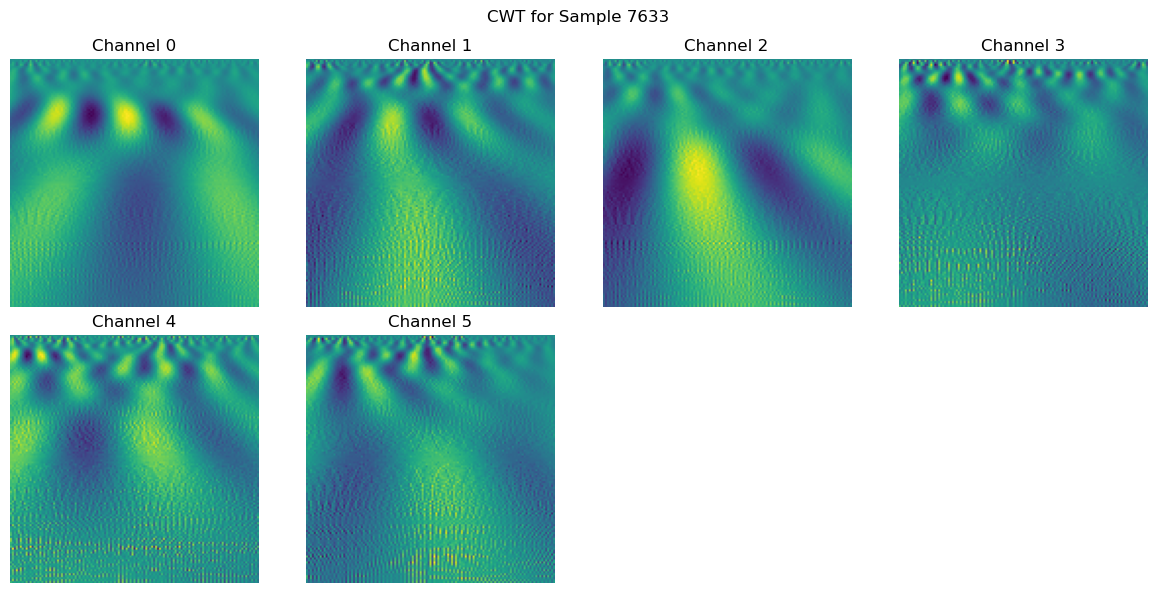

In [5]:
# Choose a random sample index
sample_index = random.randint(0, x_train.shape[0] - 1)

# Plot the CWT images for all channels in that sample
plt.figure(figsize=(12, 6))
for ch in range(x_train.shape[3]):  # Automatically use available channels
    plt.subplot(2, 4, ch + 1)
    plt.imshow(x_train[sample_index, :, :, ch], cmap='viridis')
    plt.title(f'Channel {ch}')
    plt.axis('off')
plt.suptitle(f'CWT for Sample {sample_index}')
plt.tight_layout()
plt.show()

# Machine Learning

This will use Pytorch to do training on the dataset pre-processed into sonographs. This is memory-optimized to ensure that MPS does
not have problems with memory leaking, and ensure that we can maintain a large enough batch size.

If MPS is possible, then that device feature will be used. This will offload much of the training to the graphics cores, but some of
The main processor will still be used for training, especially in the beginning. This is a memory-intensive task, and expect the memory pressure at first to be near 50GB, but it does reduce down to approximately 20GB after dataloading. This will be intensive on any machine that does not have 32GB of memory.

This training will run for ten epochs, to ensure that we can reach a high enough accuracy with the test dataset (validation data)

In [39]:
# Model definition
class CNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNLSTM, self).__init__()
        input_shape = (127, 127, 6)
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 63x63

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 31x31

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
        )
        # Infer CNN output size dynamically
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # combine batch and time for CNN
        x = self.cnn(x)
        x = x.view(B, T, -1)  # separate batch and time
        out, _ = self.lstm(x)
        # Use output of last timestep
        return self.classifier(out[:, -1, :])

In [ ]:
# New version of ML Model with CNN based on CWT Sonograms, and LSTM for temporal analysis

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")
    
# Better randomization and memory allocation
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = len(label_dict)
epochs = 10
accumulation_steps = 2
time_steps = 8  # number of temporal slices per sample

# Assume x_train, x_test, y_train, y_test are defined elsewhere
# For example, x_train shape: (N, 127, 127, 6)
# y_train shape: (N,)
# Make sure data is torch tensor or numpy array accordingly

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
index_to_label = {label: idx for idx, label in enumerate(sorted(set(y_all)))}
y_train_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_train])
y_test_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_test])

def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train).float().permute(0, 3, 1, 2))  # (N, C, H, W)
# x_test_tensor = normalize(torch.tensor(x_test).float().permute(0, 3, 1, 2))
x_train_tensor = normalize(x_train.detach().clone().float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.detach().clone().float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    """
    Pads tensor along dimension `dim` to a size that is a multiple of `multiple`.
    """
    size = tensor.size(dim)
    remainder = size % multiple
    if remainder == 0:
        return tensor  # no padding needed
    padding_size = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = padding_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # Use ignore_index -100 for padding labels
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)

# Reshape to (batch, time_steps, channels, H, W)
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # input_shape[::-1] flips (H,W,C) -> (C,H,W)
y_train_seq = y_train_tensor.view(num_train_batches, time_steps)

x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

# We only use the label of the last timestep for training/classification
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

model = CNNLSTM(input_channels=6, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # ignore padded labels in loss
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100  # only count non-padded labels
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            # SAFE cleanup
            del chunk_inputs, chunk_labels, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_seq_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.12GB, Reserved=1.10GB


## Save Model

Save the trained model for later use

In [32]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [15]:
print("x_train shape:", x_train.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([21583, 127, 127, 6])
x_train_tensor shape: torch.Size([21584, 6, 127, 127])
x_train_tensor stats: mean = 5.142829304777274e-12 std = 0.9999448657035828
Sample input min/max: -8.414401054382324 8.0171480178833


# Validations
---

This will validate that the trained data can properly validate the test data set after training

In [30]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

<All keys matched successfully>

## Random Prediction

Pick a random sample from the HandGestures wavelets and do a prediction

In [34]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import os

# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
label_dict = data["label_dict"]

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/Josh59.csv"
cwt_tensor = process_single_csv_cwt(csv_path)  # shape: (1, 127, 127, 6)

# Prepare input tensor
x_single = torch.from_numpy(cwt_tensor).permute(0, 3, 1, 2).float().to(device)  # (1, 6, 127, 127)
x_single = x_single.unsqueeze(1)  # reshape to (1, 1, 6, 127, 127)

# Infer true label from path
label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
label_name = label_folder.split("_")[0]  # Strip variants like '_variant'
true_label_id = label_dict.get(label_name, None)
true_idx = label_id_to_index.get(true_label_id, -1)
true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# Run inference
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(x_single)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)

# Decode prediction
pred_idx = pred.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label:     {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


DataFrame shape: (600, 9)
Timestamps (raw): [55007 55064 55120 55177 55233 55289 55346 55403 55461 55519]
Unique timestamps: 600
Min timestamp: 55007
Max timestamp: 90962
Cleaned timestamps shape: (600,)
Duration (s): 35.955
Estimated target_len: 1797
Processing channel 1/6


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Processing channel 2/6


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.13it/s]


Processing channel 3/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 188.08it/s]


Processing channel 4/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.08it/s]


Processing channel 5/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 176.87it/s]


Processing channel 6/6


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 187.75it/s]

Single Sample Inference Result:
Predicted Label: tonic (index 2, id 2)
True Label:     UNKNOWN (index -1, id None)

Per-Class Probabilities:
normal         : 0.0000
postural       : 0.0001
tonic          : 0.9999
tremor         : 0.0000


In [37]:
import torch.nn.functional as F

# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load dataset
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]
y_test = cwt_data["y_test"]

unique_label_ids = sorted(set(y_test))
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

x_test_tensor = x_test.permute(0, 3, 1, 2).float()

time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]

model.to(device)
model.eval()

sample_idx = random.randint(0, x_test_seq.size(0) - 1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)
y_single = y_test_seq[sample_idx:sample_idx+1]

with torch.no_grad():
    outputs = model(x_single)  # logits
    probs = F.softmax(outputs, dim=1)  # probabilities over classes
    pred = torch.argmax(probs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


Single Sample Inference Result:
Predicted Label: tonic (index 2, id 2)
True Label: tonic (index 2, id 2)

Per-Class Probabilities:
normal         : 0.0000
postural       : 0.0000
tonic          : 1.0000
tremor         : 0.0000


In [27]:
# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup (check hardware in platform)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load custom dataset (example)
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]  # shape: (N, 127, 127, 6)
y_test = cwt_data["y_test"]  # shape: (N,)

# Unique sorted label IDs present in y_test (assumes these match model class ordering)
unique_label_ids = sorted(set(y_test))

# Map model class index -> label ID
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}

# Convert y_test numeric labels to indices according to unique_label_ids for shuffling & batching
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

# Shuffle dataset
perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

# Convert to torch tensor with channels first
x_test_tensor = x_test.permute(0, 3, 1, 2).float()

# Pad samples so total length is multiple of time_steps
time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)

y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Reshape into sequences (B, T, C, H, W)
num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]  # last timestep label

model.to(device)
model.eval()

# Select a single random sample index
sample_idx = random.randint(0, x_test_seq.size(0) - 1)

# Extract the single sample and label, add batch dimension (B=1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)  # shape (1, T, C, H, W)
y_single = y_test_seq[sample_idx:sample_idx+1]            # shape (1,)

with torch.no_grad():
    outputs = model(x_single)  # shape (1, num_classes)
    pred = torch.argmax(outputs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()

# Map indices back to original label IDs
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)

# Map label IDs to string names, fallback to UNKNOWN if not found
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

Single Sample Inference Result:
Predicted Label: tonic_walking (index 23, id 25448)
True Label: tonic_walking (index 23, id 25448)


## Prediction Accuracy

Do an evaluation over the entire dataset and make sure the validation accuracy matched the training

In [34]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# Load custom dataset (example)
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]  # shape: (N, 127, 127, 6)
y_test = cwt_data["y_test"]  # shape: (N,)

# Assume label_to_index from training or create mapping if needed
label_to_index = {label: idx for idx, label in enumerate(sorted(set(y_test)))}
y_test_idx = np.array([label_to_index[y] for y in y_test])

# Shuffle dataset (optional)
perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

# Convert to torch tensor with channels first
x_test_tensor = x_test.permute(0, 3, 1, 2).float()

# Pad samples so total length is multiple of time_steps
time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)

y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Reshape into sequences (B, T, C, H, W)
num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]  # last timestep label

# --- Memory-optimized inference starts here ---

batch_size = 2  # Adjust batch size for memory limits

def chunkify(tensor, chunk_size, dim=0):
    return [tensor[i:i+chunk_size] for i in range(0, tensor.size(dim), chunk_size)]

x_chunks = chunkify(x_test_seq, batch_size, dim=0)
y_chunks = chunkify(y_test_seq, batch_size, dim=0)

all_preds = []
all_labels = []

model.to(device)
model.eval()

from tqdm import tqdm  # make sure this import is present

with torch.no_grad():
    for x_chunk, y_chunk in tqdm(zip(x_chunks, y_chunks), total=len(x_chunks), desc="Inference"):
        x_chunk = x_chunk.to(device)
        y_chunk = y_chunk.to(device)
        
        outputs = model(x_chunk)  # shape (B, num_classes)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.append(preds.cpu())
        all_labels.append(y_chunk.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

mask = all_labels != -100
accuracy = (all_preds[mask] == all_labels[mask]).float().mean().item() * 100

print(f"Final Inference Accuracy: {accuracy:.2f}%")

# Optional diagnostics
print(f"Unique predicted labels: {all_preds.unique().numpy()}")
print(f"Unique true labels: {all_labels[mask].unique().numpy()}")
print(f"Predicted label counts: {torch.bincount(all_preds[mask]).numpy()}")
print(f"True label counts: {torch.bincount(all_labels[mask]).numpy()}")

Inference: 100%|██████████████████████████████| 266/266 [00:03<00:00, 74.24it/s]

Final Inference Accuracy: 100.00%
Unique predicted labels: [0 1 2 3]
Unique true labels: [0 1 2 3]
Predicted label counts: [189 101  87 153]
True label counts: [189 101  87 153]


# Visualizations

Insights that were gathered from the data training and validation work

In [35]:
# Load history data from training
history = pd.read_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv")

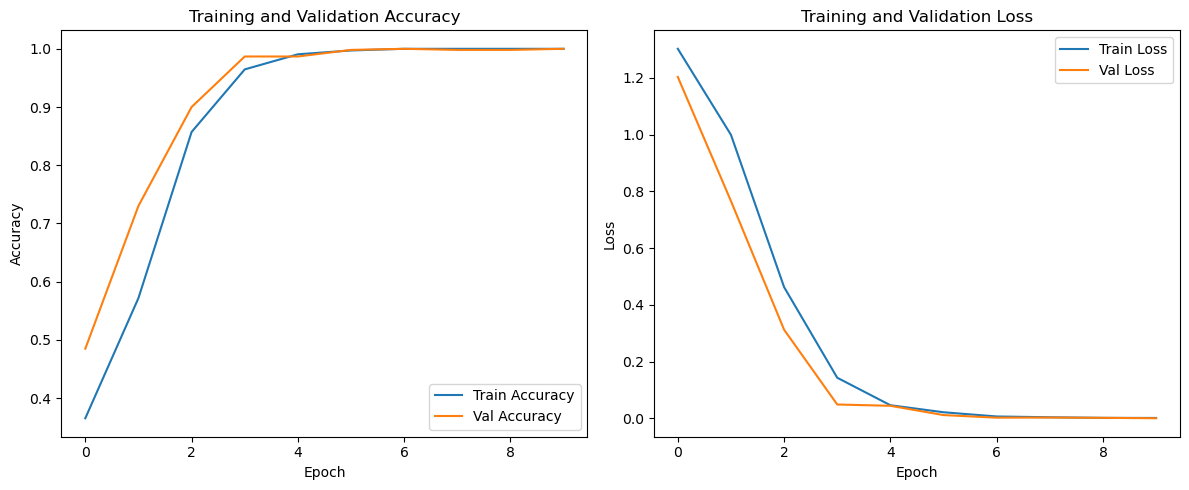

In [36]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


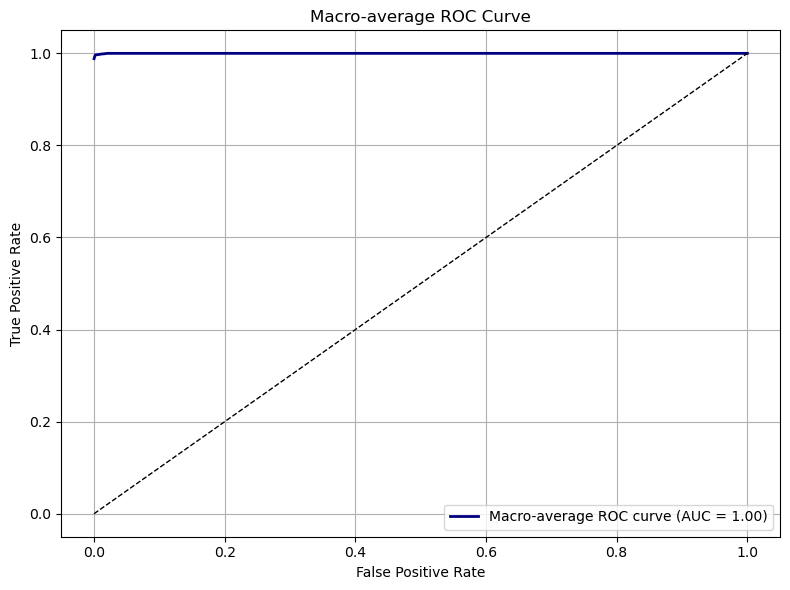

In [32]:
def compute_roc_auc(model, loader, n_classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
            torch.mps.empty_cache()

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    # One-hot encode the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Compute and plot ROC-AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, num_classes)

plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
